In [1]:
from sklearn.datasets import make_moons, make_swiss_roll
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [206]:
X1 = make_moons(5000)[0]
swiss_roll = make_swiss_roll(5000)[0]
X0 = np.stack((swiss_roll[:,0],swiss_roll[:,2]),axis=1) 

X0 = (X0-X0.mean(axis=0,keepdims=True))/X0.std(axis=0,keepdims=True)
X1 = (X1-X1.mean(axis=0,keepdims=True))/X1.std(axis=0,keepdims=True)

X0 = np.random.randn(5000,2)

X0 = torch.from_numpy(X0).to(dtype=torch.float32,device=device)
X1 = torch.from_numpy(X1).to(dtype=torch.float32,device=device)

In [4]:
def rectified_interpolant(x0,x1,t):
    return (1-t)*x0 + t*x1

def rectified_vector(xt,x0,x1,t):
    return x1-x0

In [5]:
def trigonometric_interpolant(x0,x1,t):
    return torch.cos(0.5*np.pi*t)*x0 + torch.sin(0.5*np.pi*t)*x1

def trigonometric_vector(xt,x0,x1,t):
    return 0.5*np.pi*(-torch.sin(0.5*np.pi*t)*x0 + torch.cos(0.5*np.pi*t)*x1)

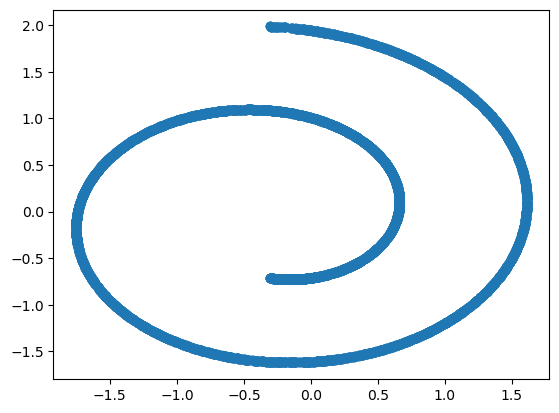

In [7]:
plt.scatter(X1[:25,0].detach().cpu(),X1[:25,1].detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

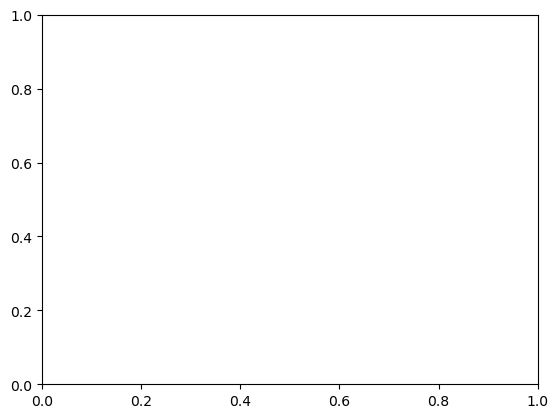

In [8]:
# for i in range(len(X0)):
# plt.quiver(X1[:25,0],X1[:25,1],(X0-X1)[:25,0],(X0-X1)[:25,1],scale=1,angles='xy',scale_units='xy')
# plt.scatter(X1[:25,0],X1[:25,1],c='b')
# plt.scatter(X0[:25,0],X0[:25,1],c='y')
# Xt = rectified_interpolant(X0,X1,0.5)
# plt.scatter(Xt[:25,0],Xt[:25,1],c='g')

In [ ]:
class NeuralNet(nn.Module):
    
    def __init__(self,inp_dim,hid_dim,num_hid_layers,out_dim,time_emd_dim):
        
        
        self.layers = nn.Sequential(
                        nn.Linear(inp_dim + time_emd_dim,hid_dim),
                        nn.ReLU(),
                        *[m for _ in range(num_hid_layers) for m in (nn.Linear(hid_dim, hid_dim), nn.ReLU())],
                        nn.Linear(hid_dim,2)
                        )  
        
    def forward(self,x,t):
        
        
        
    def get_encodings(x,num_freq):
        encoded = [x]
        for i in range(num_freq):
            encoded.append(torch.sin(2**i*torch.pi*x))
            encoded.append(torch.cos(2**i*torch.pi*x))
        return torch.cat(encoded,dim=-1)

In [133]:
def get_encodings(x,num_freq): #encoding used in NeRF
    encoded = [x]
    for i in range(num_freq):
        encoded.append(torch.sin(2**i*torch.pi*x))
        encoded.append(torch.cos(2**i*torch.pi*x))
    return torch.cat(encoded,dim=-1)

def get_t_encodings(t,num_freqs):
    
    enc = torch.full((t.shape[0],num_freqs*2+1),2,dtype=torch.float32).to(device)
    p = torch.arange(num_freqs)[None,:].to(device)
    enc[:,1:num_freqs+1] = (enc[0,:num_freqs]**p)[:,None,:]*t*np.pi
    enc[:,num_freqs+1:] = enc[:,1:num_freqs+1]
    enc[:,1:num_freqs+1] = torch.sin(enc[:,1:num_freqs+1])
    enc[:,num_freqs+1:] = torch.cos(enc[:,num_freqs+1:])
    enc[:,0] = t[:,0]
    return enc

In [197]:
num_hid_layers = 3
num_freq = 5
model = nn.Sequential(
        nn.Linear(2+num_freq*2+1,128),
        nn.ReLU(),
        *[m for _ in range(num_hid_layers) for m in (nn.Linear(128, 128), nn.ReLU())],
        nn.Linear(128,2)
)   

model = model.to(device)

In [207]:

learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
num_epoch = 1000
mb_size = 512
loss_func = torch.nn.MSELoss()

interpolant = trigonometric_interpolant
cond_vec_field = trigonometric_vector
for e in range(num_epoch):
    
    acc_loss = 0
    for b in range(len(X0)//mb_size + 1):
        x0_ind = torch.randint(0,len(X0),(mb_size,))
        x1_ind = torch.randint(0,len(X0),(mb_size,))

        x0 = X0[x0_ind]
        x1 = X1[x1_ind]

        rand_time = torch.rand((mb_size,1),device=device)
        enc_rand_time = get_t_encodings(rand_time,num_freq)
        xt = interpolant(x0,x1,rand_time)

        cvf_target = cond_vec_field(xt,x0,x1,rand_time)
        vec_pred = model(torch.concat((xt,enc_rand_time),axis=1))

        optimizer.zero_grad()
        loss = loss_func(cvf_target.detach(),vec_pred)
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()

    print(f"epoch:{e} loss: {acc_loss/b}")
    
    

epoch:0 loss: 2.7933097415500217
epoch:1 loss: 2.6335390408833823
epoch:2 loss: 2.596413877275255
epoch:3 loss: 2.590054088168674
epoch:4 loss: 2.4980191124810114
epoch:5 loss: 2.4832579824659557
epoch:6 loss: 2.485023842917548
epoch:7 loss: 2.416178570853339
epoch:8 loss: 2.415643056233724
epoch:9 loss: 2.416513866848416
epoch:10 loss: 2.422331174214681
epoch:11 loss: 2.3207498523924084
epoch:12 loss: 2.406429926554362
epoch:13 loss: 2.332875715361701
epoch:14 loss: 2.3849661350250244
epoch:15 loss: 2.444653696484036
epoch:16 loss: 2.47722856203715
epoch:17 loss: 2.399684429168701
epoch:18 loss: 2.4176454808976917
epoch:19 loss: 2.4103156328201294
epoch:20 loss: 2.4370779196421304
epoch:21 loss: 2.383201175265842
epoch:22 loss: 2.3816821442710028
epoch:23 loss: 2.3863046831554837
epoch:24 loss: 2.439837005403307
epoch:25 loss: 2.3908678690592446
epoch:26 loss: 2.391534540388319
epoch:27 loss: 2.413017882241143
epoch:28 loss: 2.418181472354465
epoch:29 loss: 2.3955508867899575
epoch:30

epoch:242 loss: 2.3527031209733753
epoch:243 loss: 2.364911158879598
epoch:244 loss: 2.359818047947354
epoch:245 loss: 2.373711003197564
epoch:246 loss: 2.4269409709506564
epoch:247 loss: 2.316377811961704
epoch:248 loss: 2.307159503300985
epoch:249 loss: 2.3485955397288003
epoch:250 loss: 2.3852623303731284
epoch:251 loss: 2.3750585185156927
epoch:252 loss: 2.36561557981703
epoch:253 loss: 2.332475437058343
epoch:254 loss: 2.382473203870985
epoch:255 loss: 2.357840061187744
epoch:256 loss: 2.3355224397447376
epoch:257 loss: 2.371879630618625
epoch:258 loss: 2.399479971991645
epoch:259 loss: 2.338353819317288
epoch:260 loss: 2.3628105454974704
epoch:261 loss: 2.356373111406962
epoch:262 loss: 2.3652593427234225
epoch:263 loss: 2.3214583926730685
epoch:264 loss: 2.379435910118951
epoch:265 loss: 2.4896843433380127
epoch:266 loss: 2.3428258895874023
epoch:267 loss: 2.360381656222873
epoch:268 loss: 2.3689310550689697
epoch:269 loss: 2.3945807615915933
epoch:270 loss: 2.3071520593431263
e

epoch:481 loss: 2.373658405409919
epoch:482 loss: 2.3461090326309204
epoch:483 loss: 2.3980726401011148
epoch:484 loss: 2.320031483968099
epoch:485 loss: 2.325501905547248
epoch:486 loss: 2.383367511961195
epoch:487 loss: 2.3623804251352944
epoch:488 loss: 2.402659946017795
epoch:489 loss: 2.3632658587561712
epoch:490 loss: 2.3544763459099665
epoch:491 loss: 2.332713656955295
epoch:492 loss: 2.4168585936228433
epoch:493 loss: 2.421505027347141
epoch:494 loss: 2.3280176056755915
epoch:495 loss: 2.4081620110405817
epoch:496 loss: 2.341866453488668
epoch:497 loss: 2.3639309803644815
epoch:498 loss: 2.30173126856486
epoch:499 loss: 2.3226591613557606
epoch:500 loss: 2.3462777932484946
epoch:501 loss: 2.4109541840023465
epoch:502 loss: 2.3546766440073648
epoch:503 loss: 2.367720193333096
epoch:504 loss: 2.326369457774692
epoch:505 loss: 2.3290874428219266
epoch:506 loss: 2.448554436365763
epoch:507 loss: 2.3817100524902344
epoch:508 loss: 2.3999033768971763
epoch:509 loss: 2.364184988869561

epoch:720 loss: 2.349936286608378
epoch:721 loss: 2.318241834640503
epoch:722 loss: 2.363720562722948
epoch:723 loss: 2.3971279991997614
epoch:724 loss: 2.340962979528639
epoch:725 loss: 2.3316233158111572
epoch:726 loss: 2.30255573325687
epoch:727 loss: 2.39273903104994
epoch:728 loss: 2.410413000318739
epoch:729 loss: 2.3391235139634876
epoch:730 loss: 2.3192683855692544
epoch:731 loss: 2.3271746502982245
epoch:732 loss: 2.388511392805311
epoch:733 loss: 2.3913552231258817
epoch:734 loss: 2.330968631638421
epoch:735 loss: 2.3284238974253335
epoch:736 loss: 2.421068721347385
epoch:737 loss: 2.408470074335734
epoch:738 loss: 2.3608131408691406
epoch:739 loss: 2.348856872982449
epoch:740 loss: 2.3065555890401206
epoch:741 loss: 2.3625508149464927
epoch:742 loss: 2.333664549721612
epoch:743 loss: 2.369180917739868
epoch:744 loss: 2.3297225766711764
epoch:745 loss: 2.3183946079678006
epoch:746 loss: 2.3593282964494495
epoch:747 loss: 2.3079678350024753
epoch:748 loss: 2.329391982820299
ep

epoch:958 loss: 2.3744647237989636
epoch:959 loss: 2.404319683710734
epoch:960 loss: 2.3647436565823026
epoch:961 loss: 2.362841089566549
epoch:962 loss: 2.3302076127794056
epoch:963 loss: 2.3259744114345975
epoch:964 loss: 2.3162074353959827
epoch:965 loss: 2.4056015014648438
epoch:966 loss: 2.3610359695222645
epoch:967 loss: 2.4455173280504017
epoch:968 loss: 2.3342364364200168
epoch:969 loss: 2.334346877204047
epoch:970 loss: 2.342499362097846
epoch:971 loss: 2.3715701897939048
epoch:972 loss: 2.4000404410892062
epoch:973 loss: 2.314858145183987
epoch:974 loss: 2.3515371878941855
epoch:975 loss: 2.3677413728502064
epoch:976 loss: 2.3374874856736927
epoch:977 loss: 2.3458215528064303
epoch:978 loss: 2.354226933585273
epoch:979 loss: 2.351637045542399
epoch:980 loss: 2.321261352962918
epoch:981 loss: 2.331050064828661
epoch:982 loss: 2.3159563541412354
epoch:983 loss: 2.362683971722921
epoch:984 loss: 2.372333367665609
epoch:985 loss: 2.3476065927081637
epoch:986 loss: 2.3493369420369

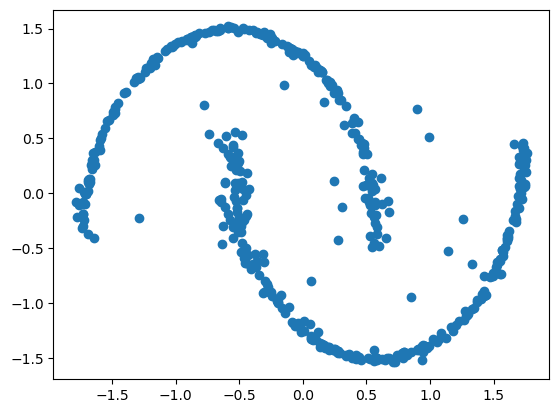

In [222]:
num_time_steps = 10

start_t = 0.0
end_t = 1.0-start_t

step_size = (end_t-start_t)/num_time_steps

X1_test = make_moons(500)[0]
swiss_roll = make_swiss_roll(500)[0]
X0_test = np.stack((swiss_roll[:,0],swiss_roll[:,2]),axis=1) 

X0_test = (X0_test-X0_test.mean(axis=0,keepdims=True))/X0_test.std(axis=0,keepdims=True)
X1_test = (X1_test-X1_test.mean(axis=0,keepdims=True))/X1_test.std(axis=0,keepdims=True)

X0_test = np.random.randn(500,2)

X0_test = torch.from_numpy(X0_test).to(dtype=torch.float32,device=device)
X1_test = torch.from_numpy(X1_test).to(dtype=torch.float32,device=device)

if start_t == 1.0:
    xt_sample = X1_test[:500].clone()
else:
    xt_sample = X0_test[:500].clone()
    
xts = []
t = torch.full((len(xt_sample),1),start_t).to(device)
for n in range(num_time_steps):
    xt_sample += step_size*model(torch.concat((xt_sample,get_t_encodings(t,num_freq)),axis=1))
    t += step_size
    xts.append(xt_sample.detach().cpu().clone())
plt.scatter(xt_sample[:,0].detach().cpu(),xt_sample[:,1].detach().cpu())

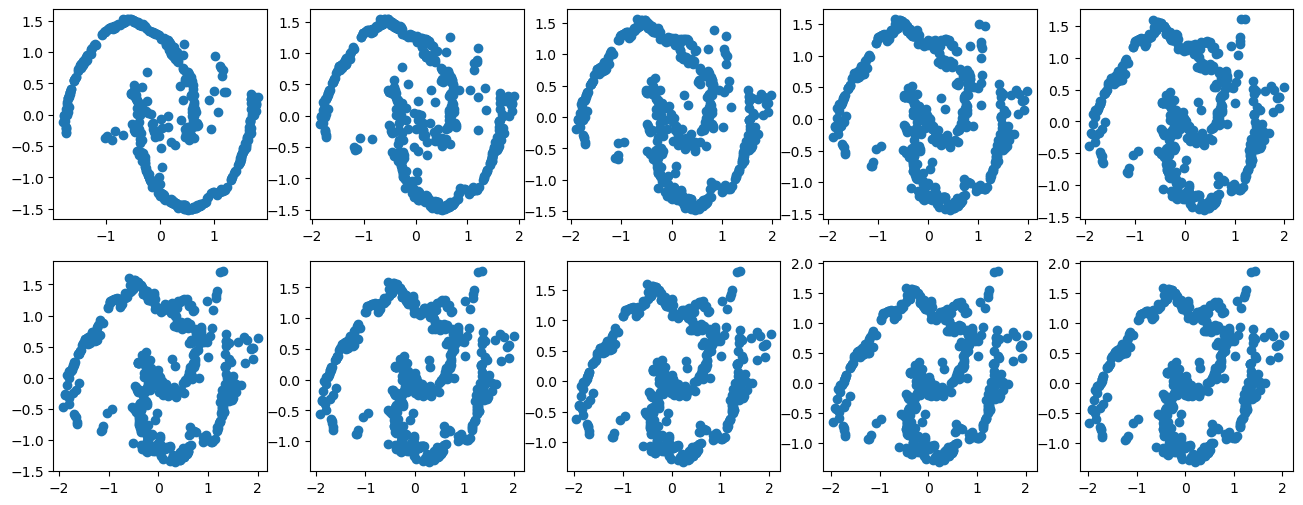

In [221]:
fig, axs = plt.subplots(2,5,figsize=(16,6))

for i in range(2):
    for j in range(5): 
        axs[i,j].scatter(xts[i*5+j][:,0].detach().cpu(),xts[i*5+j][:,1].detach().cpu())
